In [1]:
# Import required libraries
import numpy as np, pandas as pd
from scipy import stats
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import warnings
import hashlib

# Filter out annoying warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import dataset from CSV, drop duplicates, and store as a DataFrame object in RAM
dataset = pd.read_csv("../Datasets/taxi_trips_2020.csv")
dataset = pd.DataFrame(dataset).drop_duplicates()

In [3]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3889032 entries, 0 to 3889031
Data columns (total 24 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Trip ID                     3889032 non-null  object 
 1   Taxi ID                     3888831 non-null  object 
 2   Trip Start Timestamp        3889032 non-null  object 
 3   Trip End Timestamp          3888458 non-null  object 
 4   Trip Seconds                3887483 non-null  float64
 5   Trip Miles                  3889002 non-null  float64
 6   Pickup Census Tract         1782907 non-null  float64
 7   Dropoff Census Tract        1770434 non-null  float64
 8   Pickup Community Area       3610116 non-null  float64
 9   Dropoff Community Area      3520203 non-null  float64
 10  Fare                        3888700 non-null  float64
 11  Tips                        3888700 non-null  float64
 12  Tolls                       3888700 non-null  float64
 1

In [4]:
# Double-check for duplicated trips and rename a column with a space too much
dataset.drop_duplicates(subset=['Trip ID'], inplace=True)
dataset.rename(columns={'Dropoff Centroid  Location':'Dropoff Centroid Location'}, inplace=True)

In [5]:
# Drop all rides without any taxi ID and reset index
dataset.drop(dataset[dataset['Taxi ID'].isnull() == True].index, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [6]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3888831 entries, 0 to 3888830
Data columns (total 24 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Trip ID                     3888831 non-null  object 
 1   Taxi ID                     3888831 non-null  object 
 2   Trip Start Timestamp        3888831 non-null  object 
 3   Trip End Timestamp          3888257 non-null  object 
 4   Trip Seconds                3887282 non-null  float64
 5   Trip Miles                  3888801 non-null  float64
 6   Pickup Census Tract         1782893 non-null  float64
 7   Dropoff Census Tract        1770420 non-null  float64
 8   Pickup Community Area       3610077 non-null  float64
 9   Dropoff Community Area      3520164 non-null  float64
 10  Fare                        3888499 non-null  float64
 11  Tips                        3888499 non-null  float64
 12  Tolls                       3888499 non-null  float64
 1

In [7]:
# Drop everything that has either no starting point or no end point, reset index
# It may be that those that do no have coordinates assigned started or ended outside of Chicago, which is okay to leave out
dataset.drop(dataset[
             (dataset['Pickup Centroid Location'].isnull() == True)
             |
             (dataset['Dropoff Centroid Location'].isnull() == True)
             ].index, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [8]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467307 entries, 0 to 3467306
Data columns (total 24 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Trip ID                     3467307 non-null  object 
 1   Taxi ID                     3467307 non-null  object 
 2   Trip Start Timestamp        3467307 non-null  object 
 3   Trip End Timestamp          3467307 non-null  object 
 4   Trip Seconds                3466742 non-null  float64
 5   Trip Miles                  3467283 non-null  float64
 6   Pickup Census Tract         1750892 non-null  float64
 7   Dropoff Census Tract        1750892 non-null  float64
 8   Pickup Community Area       3466620 non-null  float64
 9   Dropoff Community Area      3460936 non-null  float64
 10  Fare                        3467026 non-null  float64
 11  Tips                        3467026 non-null  float64
 12  Tolls                       3467026 non-null  float64
 1

In [9]:
# Drop rides with no fare value, so where not even 0 is entered, reset index
dataset.drop(dataset[dataset['Fare'].isnull() == True].index, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [10]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467026 entries, 0 to 3467025
Data columns (total 24 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Trip ID                     3467026 non-null  object 
 1   Taxi ID                     3467026 non-null  object 
 2   Trip Start Timestamp        3467026 non-null  object 
 3   Trip End Timestamp          3467026 non-null  object 
 4   Trip Seconds                3466480 non-null  float64
 5   Trip Miles                  3467005 non-null  float64
 6   Pickup Census Tract         1750704 non-null  float64
 7   Dropoff Census Tract        1750704 non-null  float64
 8   Pickup Community Area       3466339 non-null  float64
 9   Dropoff Community Area      3460656 non-null  float64
 10  Fare                        3467026 non-null  float64
 11  Tips                        3467026 non-null  float64
 12  Tolls                       3467026 non-null  float64
 1

In [11]:
# Drop census tract and community area data as this can be later done accurately with hexagons
dataset.drop(columns=[
    'Pickup Census Tract',
    'Dropoff Census Tract',
    'Pickup Community Area',
    'Dropoff Community Area',
    'Community Areas'
], inplace=True)

In [12]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467026 entries, 0 to 3467025
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Trip ID                     3467026 non-null  object 
 1   Taxi ID                     3467026 non-null  object 
 2   Trip Start Timestamp        3467026 non-null  object 
 3   Trip End Timestamp          3467026 non-null  object 
 4   Trip Seconds                3466480 non-null  float64
 5   Trip Miles                  3467005 non-null  float64
 6   Fare                        3467026 non-null  float64
 7   Tips                        3467026 non-null  float64
 8   Tolls                       3467026 non-null  float64
 9   Extras                      3467026 non-null  float64
 10  Trip Total                  3467026 non-null  float64
 11  Payment Type                3467026 non-null  object 
 12  Company                     3467026 non-null  object 
 1

In [13]:
# Drop rides with no trip duration, so where not even 0 is entered, reset index
dataset.drop(dataset[dataset['Trip Seconds'].isnull() == True].index, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [14]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3466480 entries, 0 to 3466479
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Trip ID                     3466480 non-null  object 
 1   Taxi ID                     3466480 non-null  object 
 2   Trip Start Timestamp        3466480 non-null  object 
 3   Trip End Timestamp          3466480 non-null  object 
 4   Trip Seconds                3466480 non-null  float64
 5   Trip Miles                  3466459 non-null  float64
 6   Fare                        3466480 non-null  float64
 7   Tips                        3466480 non-null  float64
 8   Tolls                       3466480 non-null  float64
 9   Extras                      3466480 non-null  float64
 10  Trip Total                  3466480 non-null  float64
 11  Payment Type                3466480 non-null  object 
 12  Company                     3466480 non-null  object 
 1

In [15]:
# Drop rides with no distance, so where not even 0 is entered, reset index
dataset.drop(dataset[dataset['Trip Miles'].isnull() == True].index, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [16]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3466459 entries, 0 to 3466458
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Trip ID                     3466459 non-null  object 
 1   Taxi ID                     3466459 non-null  object 
 2   Trip Start Timestamp        3466459 non-null  object 
 3   Trip End Timestamp          3466459 non-null  object 
 4   Trip Seconds                3466459 non-null  float64
 5   Trip Miles                  3466459 non-null  float64
 6   Fare                        3466459 non-null  float64
 7   Tips                        3466459 non-null  float64
 8   Tolls                       3466459 non-null  float64
 9   Extras                      3466459 non-null  float64
 10  Trip Total                  3466459 non-null  float64
 11  Payment Type                3466459 non-null  object 
 12  Company                     3466459 non-null  object 
 1

In [17]:
# Save timestamps as actual timestamp objects, format timestamps
dataset['Trip Start Timestamp'] = pd.to_datetime(dataset['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
dataset['Trip End Timestamp'] = pd.to_datetime(dataset['Trip End Timestamp'], format='%m/%d/%Y %I:%M:%S %p')

In [18]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3466459 entries, 0 to 3466458
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip ID                     3466459 non-null  object        
 1   Taxi ID                     3466459 non-null  object        
 2   Trip Start Timestamp        3466459 non-null  datetime64[ns]
 3   Trip End Timestamp          3466459 non-null  datetime64[ns]
 4   Trip Seconds                3466459 non-null  float64       
 5   Trip Miles                  3466459 non-null  float64       
 6   Fare                        3466459 non-null  float64       
 7   Tips                        3466459 non-null  float64       
 8   Tolls                       3466459 non-null  float64       
 9   Extras                      3466459 non-null  float64       
 10  Trip Total                  3466459 non-null  float64       
 11  Payment Type            

In [19]:
print('Trips that ended before they started:', len(dataset[(dataset['Trip End Timestamp'] - dataset['Trip Start Timestamp']).dt.total_seconds() < 0]))

Trips that ended before they started: 0


In [20]:
# Convert miles to kilometers because nobody likes imperial units
dataset['Trip Miles'] = np.round(dataset['Trip Miles'] * 1.609344, 2)
dataset.rename(columns={'Trip Miles':'Trip Kilometers'}, inplace=True)

In [21]:
print('STATISTICS')
print(50*'-')
print('Earliest trip start:\t', dataset['Trip Start Timestamp'].min())
print('Latest trip end:\t', dataset['Trip End Timestamp'].max())
print(50*'-')
print('Fastest trip:\t\t', np.round(dataset['Trip Seconds'].min(), 2), '\bs')
print('Longest trip:\t\t', np.round(dataset['Trip Seconds'].max(), 2), '\bs')
print('Average trip time:\t', np.round(dataset['Trip Seconds'].mean(), 2), '\bs')
print(50*'-')
print('Shortest trip:\t\t', np.round(dataset['Trip Kilometers'].min(), 2), '\bkm')
print('Furthest trip:\t\t', np.round(dataset['Trip Kilometers'].max(), 2), '\bkm')
print('Average trip distance:\t', np.round(dataset['Trip Kilometers'].mean(), 2), '\bkm')
print(50*'-')
print('Lowest trip fare:\t', np.round(dataset['Fare'].min(), 2), '\b$')
print('Highest trip fare:\t', np.round(dataset['Fare'].max(), 2), '\b$')
print('Average trip fare:\t', np.round(dataset['Fare'].mean(), 2), '\b$')
print(50*'-')
print('Lowest tip given:\t', np.round(dataset['Tips'].min(), 2), '\b$')
print('Highest tip given:\t', np.round(dataset['Tips'].max(), 2), '\b$')
print('Average tip given:\t', np.round(dataset['Tips'].mean(), 2), '\b$')
print(50*'-')
print('Lowest toll applied:\t', np.round(dataset['Tolls'].min(), 2), '\b$')
print('Highest toll applied:\t', np.round(dataset['Tolls'].max(), 2), '\b$')
print('Average toll applied:\t', np.round(dataset['Tolls'].mean(), 2), '\b$')
print(50*'-')
print('Lowest extra paid:\t', np.round(dataset['Extras'].min(), 2), '\b$')
print('Highest extra paid:\t', np.round(dataset['Extras'].max(), 2), '\b$')
print('Average extra paid:\t', np.round(dataset['Extras'].mean(), 2), '\b$')
print(50*'-')
print('Lowest trip total:\t', np.round(dataset['Trip Total'].min(), 2), '\b$')
print('Highest trip total:\t', np.round(dataset['Trip Total'].max(), 2), '\b$')
print('Average trip total:\t', np.round(dataset['Trip Total'].mean(), 2), '\b$')
print(50*'-')

STATISTICS
--------------------------------------------------
Earliest trip start:	 2020-01-01 00:00:00
Latest trip end:	 2021-01-01 17:15:00
--------------------------------------------------
Fastest trip:		 0.0s
Longest trip:		 86398.0s
Average trip time:	 829.17s
--------------------------------------------------
Shortest trip:		 0.0km
Furthest trip:		 1599.04km
Average trip distance:	 5.33km
--------------------------------------------------
Lowest trip fare:	 0.0$
Highest trip fare:	 9900.26$
Average trip fare:	 14.65$
--------------------------------------------------
Lowest tip given:	 0.0$
Highest tip given:	 512.0$
Average tip given:	 1.39$
--------------------------------------------------
Lowest toll applied:	 0.0$
Highest toll applied:	 90.0$
Average toll applied:	 0.0$
--------------------------------------------------
Lowest extra paid:	 0.0$
Highest extra paid:	 9900.66$
Average extra paid:	 0.78$
--------------------------------------------------
Lowest trip total:	 0.0

In [22]:
print('Amount of unique taxis:\t\t', len(dataset['Taxi ID'].unique()))
print('Amount of deviant taxi ID\'s:\t', len(dataset[dataset['Taxi ID'].str.len() != 128]))

Amount of unique taxis:		 4216
Amount of deviant taxi ID's:	 0


In [23]:
print('Payment types:', dataset['Payment Type'].unique())
print('Taxi companies:', dataset['Company'].unique())

Payment types: ['Cash' 'Prcard' 'Unknown' 'Credit Card' 'Mobile' 'Dispute' 'No Charge'
 'Prepaid']
Taxi companies: ['Flash Cab' 'Taxi Affiliation Services' 'Taxicab Insurance Agency, LLC'
 'City Service' 'Medallion Leasin' 'Top Cab Affiliation'
 'Patriot Taxi Dba Peace Taxi Associat' 'Star North Management LLC'
 'Blue Ribbon Taxi Association Inc.' '312 Medallion Management Corp'
 'Chicago Independents' 'U Taxicab' 'Chicago Taxicab' 'Globe Taxi'
 'Sun Taxi' '24 Seven Taxi' '5062 - 34841 Sam Mestas'
 'KOAM Taxi Association' 'Metro Jet Cab Association Inc.' 'Setare Inc'
 '3591 - 63480 Chuks Cab' '2733 - 74600 Benny Jona'
 '3556 - 36214 RC Andrews Cab' '3620 - 52292 David K. Cab Corp.'
 '3011 - 66308 JBL Cab Inc.' 'Choice Taxi Association' 'Metro Jet Taxi A'
 'Chicago Medallion Management' 'Nova Taxi Affiliation Llc'
 '4523 - 79481 Hazel Transit Inc' '5 Star Taxi'
 '6742 - 83735 Tasha ride inc' 'Petani Cab Corp'
 'Chicago Carriage Cab Corp' '3094 - 24059 G.L.B. Cab Co'
 '2092 - 61288 Sbeih

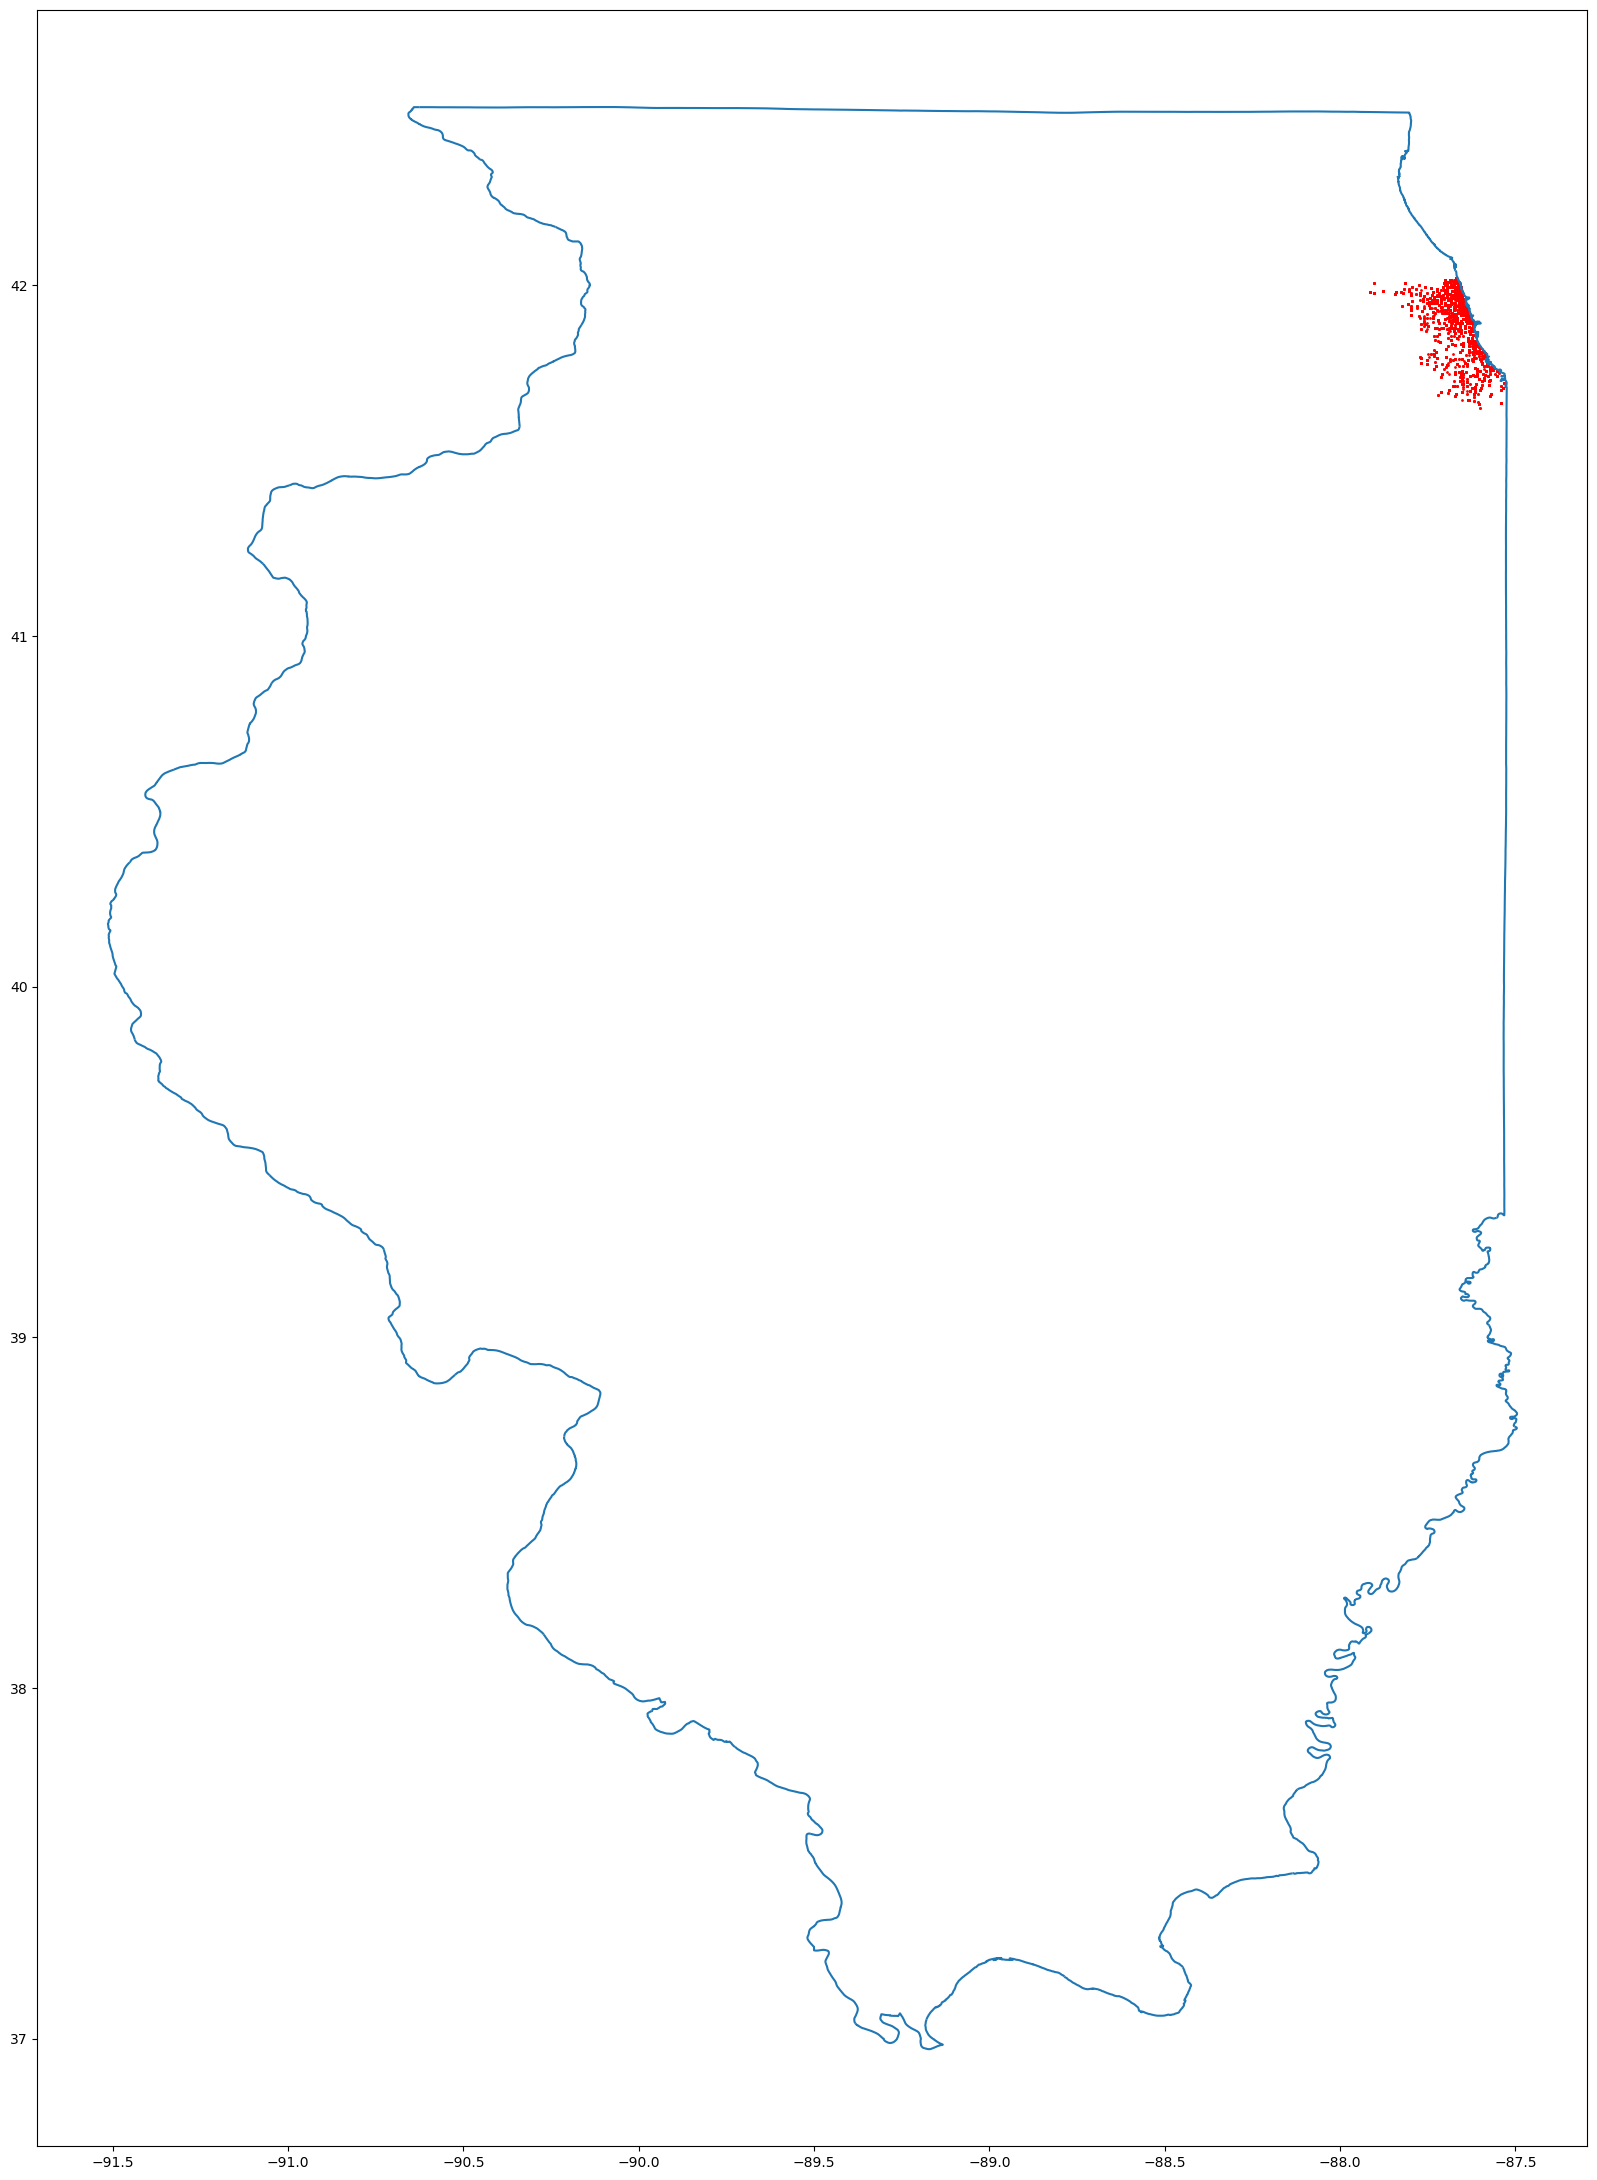

In [24]:
# Create a map to verify that all rides actually start in Chicago:
geometry = [Point(xy) for xy in zip(dataset['Pickup Centroid Longitude'], dataset['Pickup Centroid Latitude'])]
gdf = GeoDataFrame(dataset, geometry=geometry)
world = gpd.read_file('https://clearinghouse.isgs.illinois.edu/sites/clearinghouse.isgs/files/Clearinghouse/data/ISGS/Reference/zips/IL_BNDY_State.zip')
gdf.plot(ax=world.plot(figsize=(20, 40)), marker='o', color='red', markersize=1);

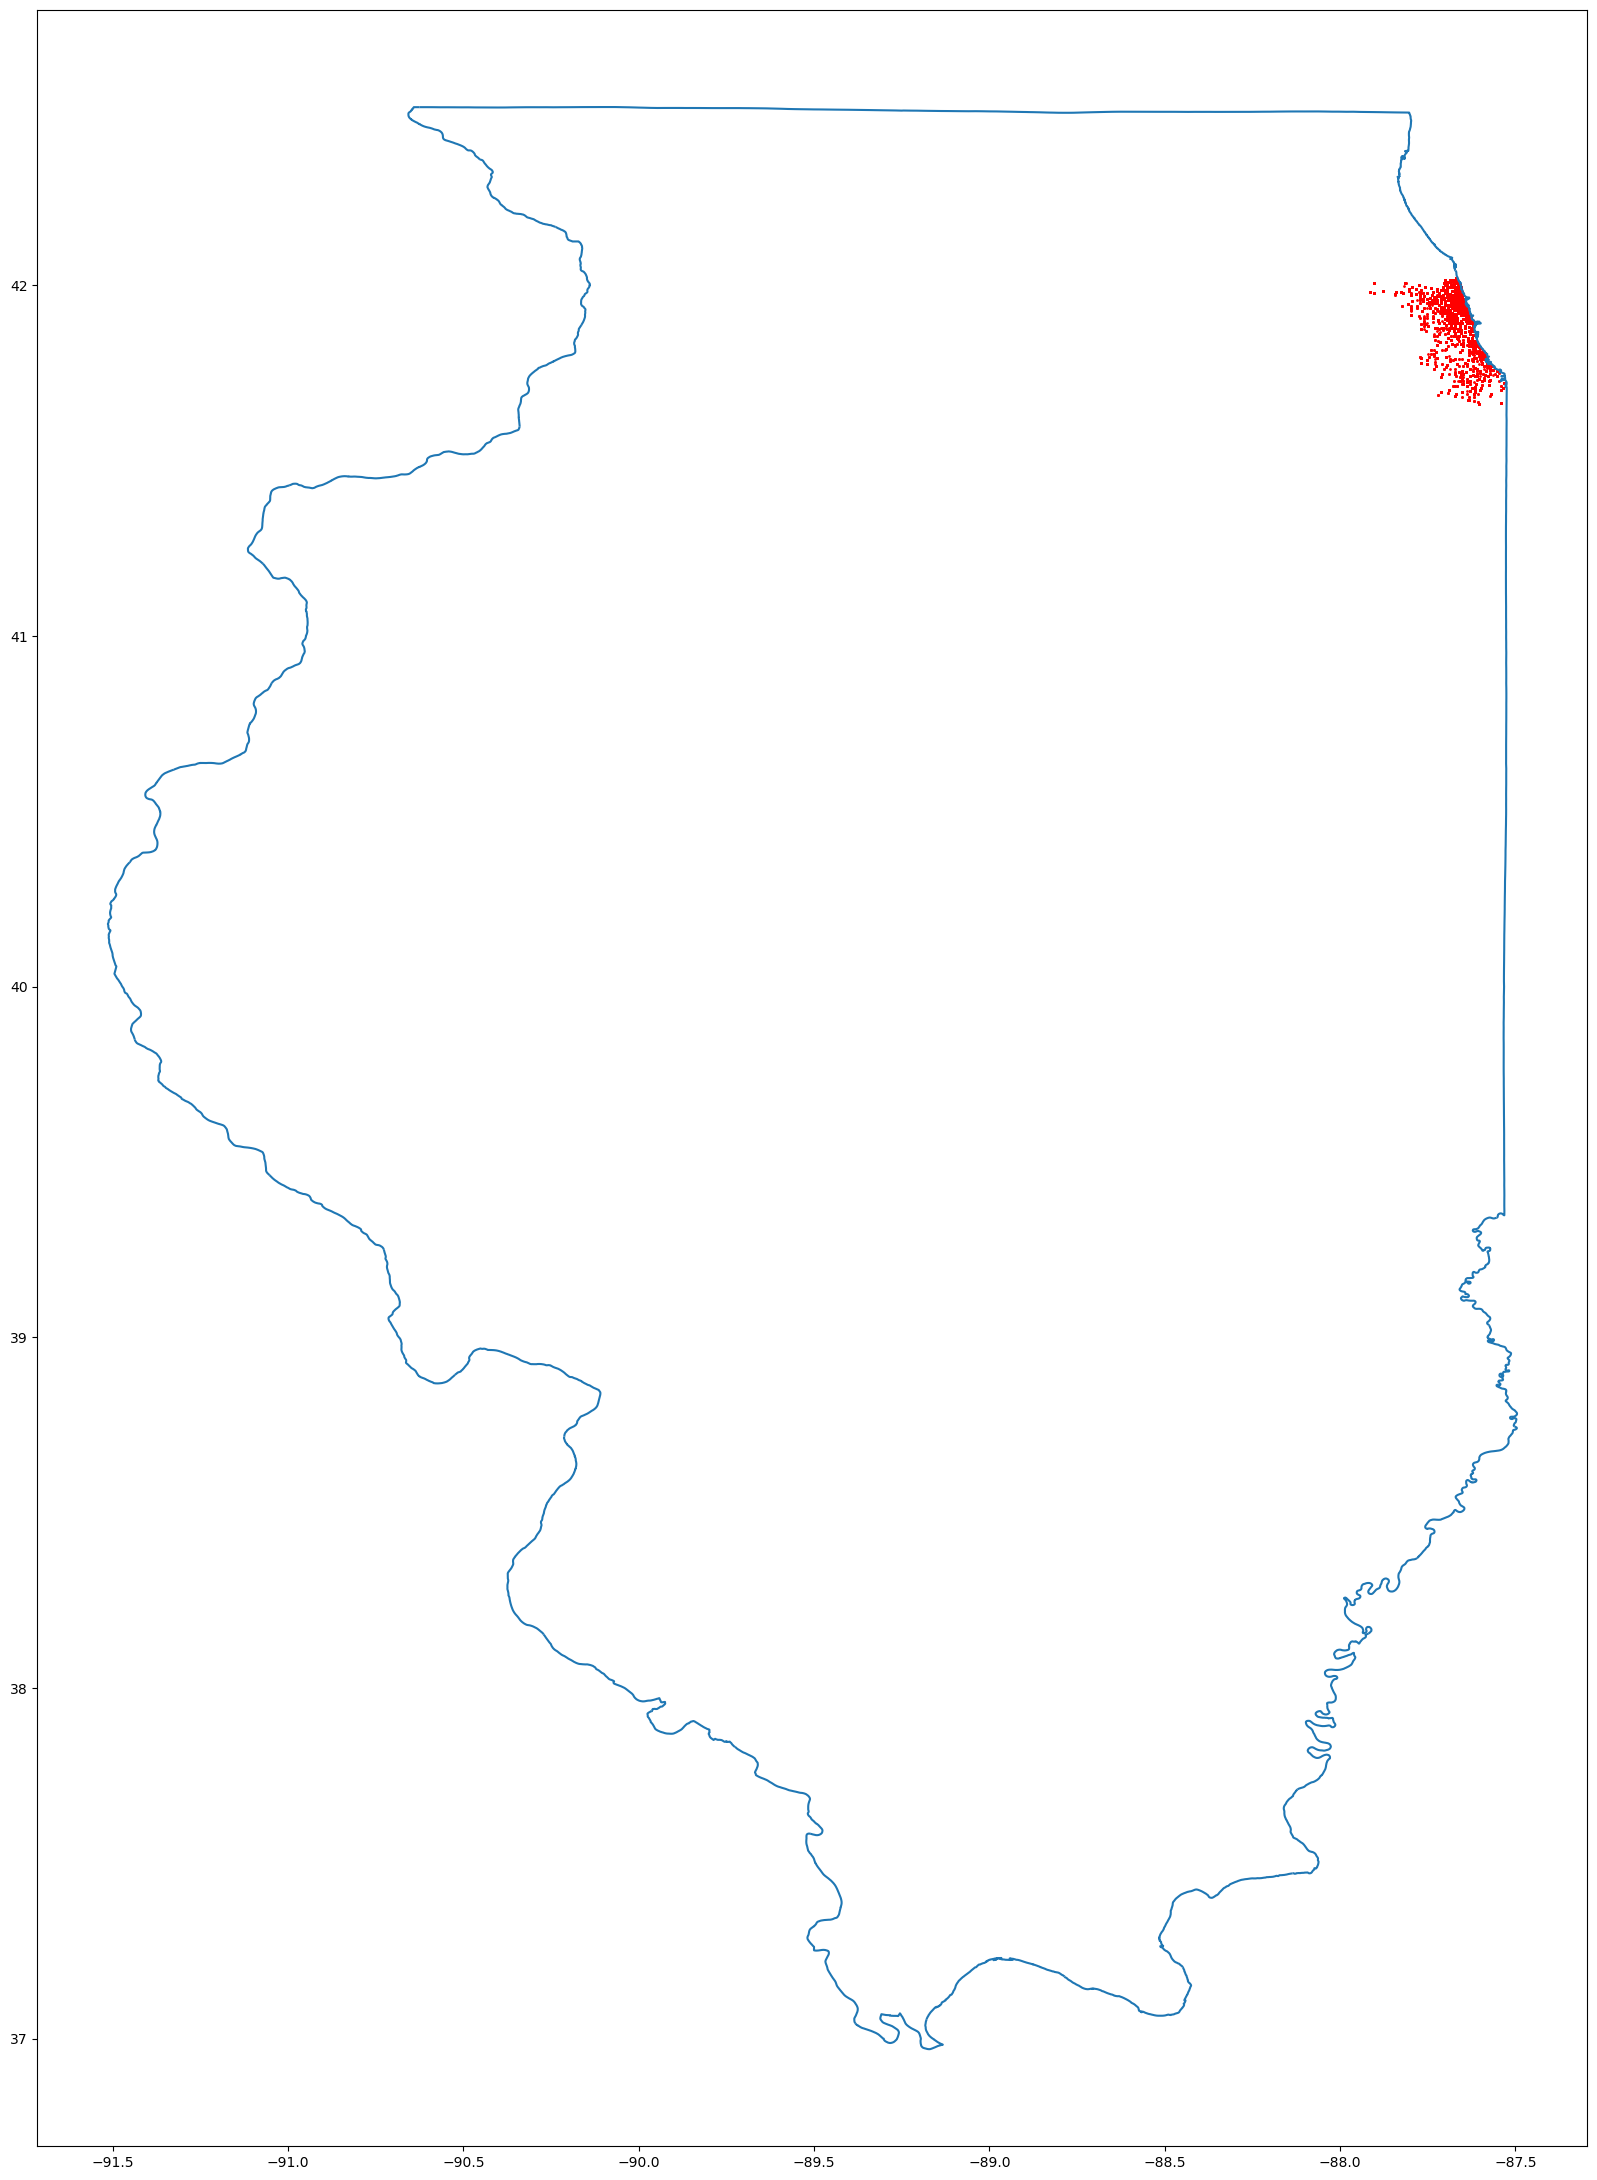

In [25]:
# Create a map to verify that all rides actually end in Chicago:
geometry = [Point(xy) for xy in zip(dataset['Dropoff Centroid Longitude'], dataset['Dropoff Centroid Latitude'])]
gdf = GeoDataFrame(dataset, geometry=geometry)
world = gpd.read_file('https://clearinghouse.isgs.illinois.edu/sites/clearinghouse.isgs/files/Clearinghouse/data/ISGS/Reference/zips/IL_BNDY_State.zip')
gdf.plot(ax=world.plot(figsize=(20, 40)), marker='o', color='red', markersize=1);

In [26]:
print('STATISTICS')
print(50*'-')
print('Earliest trip start:\t', dataset['Trip Start Timestamp'].min())
print('Latest trip end:\t', dataset['Trip End Timestamp'].max())
print(50*'-')
print('Fastest trip:\t\t', np.round(dataset['Trip Seconds'].min(), 2), '\bs')
print('Longest trip:\t\t', np.round(dataset['Trip Seconds'].max(), 2), '\bs')
print('Average trip time:\t', np.round(dataset['Trip Seconds'].mean(), 2), '\bs')
print(50*'-')
print('Shortest trip:\t\t', np.round(dataset['Trip Kilometers'].min(), 2), '\bkm')
print('Furthest trip:\t\t', np.round(dataset['Trip Kilometers'].max(), 2), '\bkm')
print('Average trip distance:\t', np.round(dataset['Trip Kilometers'].mean(), 2), '\bkm')
print(50*'-')
print('Lowest trip fare:\t', np.round(dataset['Fare'].min(), 2), '\b$')
print('Highest trip fare:\t', np.round(dataset['Fare'].max(), 2), '\b$')
print('Average trip fare:\t', np.round(dataset['Fare'].mean(), 2), '\b$')
print(50*'-')
print('Lowest tip given:\t', np.round(dataset['Tips'].min(), 2), '\b$')
print('Highest tip given:\t', np.round(dataset['Tips'].max(), 2), '\b$')
print('Average tip given:\t', np.round(dataset['Tips'].mean(), 2), '\b$')
print(50*'-')
print('Lowest toll applied:\t', np.round(dataset['Tolls'].min(), 2), '\b$')
print('Highest toll applied:\t', np.round(dataset['Tolls'].max(), 2), '\b$')
print('Average toll applied:\t', np.round(dataset['Tolls'].mean(), 2), '\b$')
print(50*'-')
print('Lowest extra paid:\t', np.round(dataset['Extras'].min(), 2), '\b$')
print('Highest extra paid:\t', np.round(dataset['Extras'].max(), 2), '\b$')
print('Average extra paid:\t', np.round(dataset['Extras'].mean(), 2), '\b$')
print(50*'-')
print('Lowest trip total:\t', np.round(dataset['Trip Total'].min(), 2), '\b$')
print('Highest trip total:\t', np.round(dataset['Trip Total'].max(), 2), '\b$')
print('Average trip total:\t', np.round(dataset['Trip Total'].mean(), 2), '\b$')
print(50*'-')

STATISTICS
--------------------------------------------------
Earliest trip start:	 2020-01-01 00:00:00
Latest trip end:	 2021-01-01 17:15:00
--------------------------------------------------
Fastest trip:		 0.0s
Longest trip:		 86398.0s
Average trip time:	 829.17s
--------------------------------------------------
Shortest trip:		 0.0km
Furthest trip:		 1599.04km
Average trip distance:	 5.33km
--------------------------------------------------
Lowest trip fare:	 0.0$
Highest trip fare:	 9900.26$
Average trip fare:	 14.65$
--------------------------------------------------
Lowest tip given:	 0.0$
Highest tip given:	 512.0$
Average tip given:	 1.39$
--------------------------------------------------
Lowest toll applied:	 0.0$
Highest toll applied:	 90.0$
Average toll applied:	 0.0$
--------------------------------------------------
Lowest extra paid:	 0.0$
Highest extra paid:	 9900.66$
Average extra paid:	 0.78$
--------------------------------------------------
Lowest trip total:	 0.0

In [27]:
# Drop outliers, reset index
dataset = dataset[(np.abs(stats.zscore(dataset[['Trip Seconds','Trip Kilometers','Fare','Tips', 'Tolls', 'Extras']])) < 3).all(axis=1)]
dataset.reset_index(drop=True, inplace=True)

In [28]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3335627 entries, 0 to 3335626
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip ID                     3335627 non-null  object        
 1   Taxi ID                     3335627 non-null  object        
 2   Trip Start Timestamp        3335627 non-null  datetime64[ns]
 3   Trip End Timestamp          3335627 non-null  datetime64[ns]
 4   Trip Seconds                3335627 non-null  float64       
 5   Trip Kilometers             3335627 non-null  float64       
 6   Fare                        3335627 non-null  float64       
 7   Tips                        3335627 non-null  float64       
 8   Tolls                       3335627 non-null  float64       
 9   Extras                      3335627 non-null  float64       
 10  Trip Total                  3335627 non-null  float64       
 11  Payment Type            

In [29]:
print('STATISTICS')
print(50*'-')
print('Earliest trip start:\t', dataset['Trip Start Timestamp'].min())
print('Latest trip end:\t', dataset['Trip End Timestamp'].max())
print(50*'-')
print('Fastest trip:\t\t', np.round(dataset['Trip Seconds'].min(), 2), '\bs')
print('Longest trip:\t\t', np.round(dataset['Trip Seconds'].max(), 2), '\bs')
print('Average trip time:\t', np.round(dataset['Trip Seconds'].mean(), 2), '\bs')
print(50*'-')
print('Shortest trip:\t\t', np.round(dataset['Trip Kilometers'].min(), 2), '\bkm')
print('Furthest trip:\t\t', np.round(dataset['Trip Kilometers'].max(), 2), '\bkm')
print('Average trip distance:\t', np.round(dataset['Trip Kilometers'].mean(), 2), '\bkm')
print(50*'-')
print('Lowest trip fare:\t', np.round(dataset['Fare'].min(), 2), '\b$')
print('Highest trip fare:\t', np.round(dataset['Fare'].max(), 2), '\b$')
print('Average trip fare:\t', np.round(dataset['Fare'].mean(), 2), '\b$')
print(50*'-')
print('Lowest tip given:\t', np.round(dataset['Tips'].min(), 2), '\b$')
print('Highest tip given:\t', np.round(dataset['Tips'].max(), 2), '\b$')
print('Average tip given:\t', np.round(dataset['Tips'].mean(), 2), '\b$')
print(50*'-')
print('Lowest toll applied:\t', np.round(dataset['Tolls'].min(), 2), '\b$')
print('Highest toll applied:\t', np.round(dataset['Tolls'].max(), 2), '\b$')
print('Average toll applied:\t', np.round(dataset['Tolls'].mean(), 2), '\b$')
print(50*'-')
print('Lowest extra paid:\t', np.round(dataset['Extras'].min(), 2), '\b$')
print('Highest extra paid:\t', np.round(dataset['Extras'].max(), 2), '\b$')
print('Average extra paid:\t', np.round(dataset['Extras'].mean(), 2), '\b$')
print(50*'-')
print('Lowest trip total:\t', np.round(dataset['Trip Total'].min(), 2), '\b$')
print('Highest trip total:\t', np.round(dataset['Trip Total'].max(), 2), '\b$')
print('Average trip total:\t', np.round(dataset['Trip Total'].mean(), 2), '\b$')
print(50*'-')

STATISTICS
--------------------------------------------------
Earliest trip start:	 2020-01-01 00:00:00
Latest trip end:	 2021-01-01 00:15:00
--------------------------------------------------
Fastest trip:		 0.0s
Longest trip:		 5556.0s
Average trip time:	 731.53s
--------------------------------------------------
Shortest trip:		 0.0km
Furthest trip:		 31.62km
Average trip distance:	 4.56km
--------------------------------------------------
Lowest trip fare:	 0.0$
Highest trip fare:	 270.01$
Average trip fare:	 12.17$
--------------------------------------------------
Lowest tip given:	 0.0$
Highest tip given:	 9.32$
Average tip given:	 1.09$
--------------------------------------------------
Lowest toll applied:	 0.0$
Highest toll applied:	 0.11$
Average toll applied:	 0.0$
--------------------------------------------------
Lowest extra paid:	 0.0$
Highest extra paid:	 72.0$
Average extra paid:	 0.52$
--------------------------------------------------
Lowest trip total:	 0.0$
Highes

In [30]:
print('Amount of instant trips:\t', len(dataset[dataset['Trip Seconds'] == 0]))
print('Amount of distanceless trips:\t', len(dataset[dataset['Trip Kilometers'] == 0]))
print('Amount of no trip fares:\t', len(dataset[dataset['Fare'] == 0]))
print('Amount of free rides:\t\t', len(dataset[dataset['Trip Total'] == 0]))
print('Tax evasion rides:\t\t', len(dataset[
    (dataset['Trip Total'] == 0) & 
    (dataset['Payment Type'].str.match('Cash')) &
    (dataset['Trip Kilometers'] > 0)
]))
print('Real distanceless trips:\t', len(dataset[
    (dataset['Trip Kilometers'] == 0) &
    (dataset['Pickup Centroid Latitude'] == dataset['Dropoff Centroid Latitude']) &
    (dataset['Pickup Centroid Longitude'] == dataset['Dropoff Centroid Longitude'])
]))
print('Money Laundering or whatever:\t', len(dataset[
    (dataset['Trip Kilometers'] == 0) &
    (dataset['Pickup Centroid Latitude'] == dataset['Dropoff Centroid Latitude']) &
    (dataset['Pickup Centroid Longitude'] == dataset['Dropoff Centroid Longitude']) &
    (dataset['Trip Total'] > 0)
]))

Amount of instant trips:	 70958
Amount of distanceless trips:	 536404
Amount of no trip fares:	 3146
Amount of free rides:		 2998
Tax evasion rides:		 1984
Real distanceless trips:	 206171
Money Laundering or whatever:	 205373


In [31]:
print('Amount of possibly wrong calculated totals:', len(dataset[
    ((dataset['Fare'] + dataset['Tips'] + dataset['Tolls'] + dataset['Extras'] - dataset['Trip Total']) < -1) |
    ((dataset['Fare'] + dataset['Tips'] + dataset['Tolls'] + dataset['Extras'] - dataset['Trip Total']) > 1)
]))

Amount of possibly wrong calculated totals: 10998


In [32]:
# Drop all rides that are actually distanceless, reset index
dataset.drop(dataset[
    (dataset['Trip Kilometers'] == 0) &
    (dataset['Pickup Centroid Latitude'] == dataset['Dropoff Centroid Latitude']) &
    (dataset['Pickup Centroid Longitude'] == dataset['Dropoff Centroid Longitude'])
].index, inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [33]:
dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129456 entries, 0 to 3129455
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip ID                     3129456 non-null  object        
 1   Taxi ID                     3129456 non-null  object        
 2   Trip Start Timestamp        3129456 non-null  datetime64[ns]
 3   Trip End Timestamp          3129456 non-null  datetime64[ns]
 4   Trip Seconds                3129456 non-null  float64       
 5   Trip Kilometers             3129456 non-null  float64       
 6   Fare                        3129456 non-null  float64       
 7   Tips                        3129456 non-null  float64       
 8   Tolls                       3129456 non-null  float64       
 9   Extras                      3129456 non-null  float64       
 10  Trip Total                  3129456 non-null  float64       
 11  Payment Type            

In [34]:
print('Amount of instant trips:\t', len(dataset[dataset['Trip Seconds'] == 0]))
print('Amount of distanceless trips:\t', len(dataset[dataset['Trip Kilometers'] == 0]))
print('Amount of no trip fares:\t', len(dataset[dataset['Fare'] == 0]))
print('Amount of free rides:\t\t', len(dataset[dataset['Trip Total'] == 0]))
print('Tax evasion rides:\t\t', len(dataset[
    (dataset['Trip Total'] == 0) & 
    (dataset['Payment Type'].str.match('Cash')) &
    (dataset['Trip Kilometers'] > 0)
]))
print('Real distanceless trips:\t', len(dataset[
    (dataset['Trip Kilometers'] == 0) &
    (dataset['Pickup Centroid Latitude'] == dataset['Dropoff Centroid Latitude']) &
    (dataset['Pickup Centroid Longitude'] == dataset['Dropoff Centroid Longitude'])
]))
print('Money Laundering or whatever:\t', len(dataset[
    (dataset['Trip Kilometers'] == 0) &
    (dataset['Pickup Centroid Latitude'] == dataset['Dropoff Centroid Latitude']) &
    (dataset['Pickup Centroid Longitude'] == dataset['Dropoff Centroid Longitude']) &
    (dataset['Trip Total'] > 0)
]))

Amount of instant trips:	 6016
Amount of distanceless trips:	 330233
Amount of no trip fares:	 2305
Amount of free rides:		 2200
Tax evasion rides:		 1984
Real distanceless trips:	 0
Money Laundering or whatever:	 0


In [35]:
# Calculate average price per kilometer
avg_price_per_km = dataset['Fare'].mean() / dataset['Trip Kilometers'].mean()

In [36]:
# To augment data, calculate missing fares by multiplying distance with average price and
# missing kilometers by dividing fare through average price
dataset.loc[dataset['Fare'] == 0, 'Fare'] = np.round(dataset[dataset['Fare'] == 0]['Trip Kilometers'] * avg_price_per_km, 2)
dataset.loc[dataset['Trip Kilometers'] == 0, 'Trip Kilometers'] = np.round(dataset[dataset['Trip Kilometers'] == 0]['Fare'] / avg_price_per_km, 2)

In [37]:
print('Amount of instant trips:\t', len(dataset[dataset['Trip Seconds'] == 0]))
print('Amount of distanceless trips:\t', len(dataset[dataset['Trip Kilometers'] == 0]))
print('Amount of no trip fares:\t', len(dataset[dataset['Fare'] == 0]))
print('Amount of free rides:\t\t', len(dataset[dataset['Trip Total'] == 0]))
print('Tax evasion rides:\t\t', len(dataset[
    (dataset['Trip Total'] == 0) & 
    (dataset['Payment Type'].str.match('Cash')) &
    (dataset['Trip Kilometers'] > 0)
]))
print('Real distanceless trips:\t', len(dataset[
    (dataset['Trip Kilometers'] == 0) &
    (dataset['Pickup Centroid Latitude'] == dataset['Dropoff Centroid Latitude']) &
    (dataset['Pickup Centroid Longitude'] == dataset['Dropoff Centroid Longitude'])
]))
print('Money Laundering or whatever:\t', len(dataset[
    (dataset['Trip Kilometers'] == 0) &
    (dataset['Pickup Centroid Latitude'] == dataset['Dropoff Centroid Latitude']) &
    (dataset['Pickup Centroid Longitude'] == dataset['Dropoff Centroid Longitude']) &
    (dataset['Trip Total'] > 0)
]))

Amount of instant trips:	 6016
Amount of distanceless trips:	 316
Amount of no trip fares:	 281
Amount of free rides:		 2200
Tax evasion rides:		 1984
Real distanceless trips:	 0
Money Laundering or whatever:	 0


In [38]:
# Recalculate total
dataset.loc[:,'Trip Total'] = dataset['Fare'] + dataset['Tips'] + dataset['Tolls'] + dataset['Extras']   

In [39]:
# Check for calculation errors
print('Amount of possibly wrong calculated totals:', len(dataset[
    ((dataset['Fare'] + dataset['Tips'] + dataset['Tolls'] + dataset['Extras'] - dataset['Trip Total']) != 0)
]))

Amount of possibly wrong calculated totals: 0


In [40]:
# Double-check whether data augmentation did not change the values too much
print('STATISTICS')
print(50*'-')
print('Shortest trip:\t\t', np.round(dataset['Trip Kilometers'].min(), 2), '\bkm')
print('Furthest trip:\t\t', np.round(dataset['Trip Kilometers'].max(), 2), '\bkm')
print('Average trip distance:\t', np.round(dataset['Trip Kilometers'].mean(), 2), '\bkm')
print(50*'-')
print('Lowest trip fare:\t', np.round(dataset['Fare'].min(), 2), '\b$')
print('Highest trip fare:\t', np.round(dataset['Fare'].max(), 2), '\b$')
print('Average trip fare:\t', np.round(dataset['Fare'].mean(), 2), '\b$')
print(50*'-')
print('Lowest trip total:\t', np.round(dataset['Trip Total'].min(), 2), '\b$')
print('Highest trip total:\t', np.round(dataset['Trip Total'].max(), 2), '\b$')
print('Average trip total:\t', np.round(dataset['Trip Total'].mean(), 2), '\b$')
print(50*'-')

STATISTICS
--------------------------------------------------
Shortest trip:		 0.0km
Furthest trip:		 103.87km
Average trip distance:	 5.26km
--------------------------------------------------
Lowest trip fare:	 0.0$
Highest trip fare:	 270.01$
Average trip fare:	 12.65$
--------------------------------------------------
Lowest trip total:	 0.0$
Highest trip total:	 279.7$
Average trip total:	 14.28$
--------------------------------------------------


In [41]:
# Import weather data from CSV, drop duplicates, and store as a DataFrame object in RAM
weather = pd.read_csv("../Datasets/weather_data.csv")
weather = pd.DataFrame(weather).drop_duplicates()

In [42]:
weather.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103568 entries, 0 to 103567
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   timestamp                   103568 non-null  object 
 1   temperature                 103433 non-null  float64
 2   dew_point                   103433 non-null  float64
 3   humidity                    103433 non-null  float64
 4   wind_speed                  103433 non-null  float64
 5   wind_gust                   103433 non-null  float64
 6   pressure                    103450 non-null  float64
 7   precipitation_rate          103444 non-null  float64
 8   precipitation_accumulation  103433 non-null  float64
dtypes: float64(8), object(1)
memory usage: 7.1+ MB


In [43]:
# Drop everything where no temperature values are present
weather.drop(weather[weather['temperature'].isnull() == True].index, inplace=True)
weather.reset_index(drop=True, inplace=True)

In [44]:
# Save timestamps as actual timestamp objects, format timestamps
weather['timestamp'] = pd.to_datetime(weather['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [45]:
# Do some unit conversion because nobody likes imperial units
weather['temperature'] = np.round((weather['temperature'] - 32.) / (9./5.), 2)
weather['dew_point'] = np.round((weather['dew_point'] - 32.) / (9./5.), 2)
weather['wind_speed'] = np.round(weather['wind_speed'] * 1.609344, 2)
weather['wind_gust'] = np.round(weather['wind_gust'] * 1.609344, 2)
weather['pressure'] = np.round(weather['pressure'] / 29.53, 4)
weather['precipitation_rate'] = np.round(weather['precipitation_rate'] * 2.54, 2)
weather['precipitation_accumulation'] = np.round(weather['precipitation_accumulation'] * 2.54, 2)

In [46]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103433 entries, 0 to 103432
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   timestamp                   103433 non-null  datetime64[ns]
 1   temperature                 103433 non-null  float64       
 2   dew_point                   103433 non-null  float64       
 3   humidity                    103433 non-null  float64       
 4   wind_speed                  103433 non-null  float64       
 5   wind_gust                   103433 non-null  float64       
 6   pressure                    103433 non-null  float64       
 7   precipitation_rate          103433 non-null  float64       
 8   precipitation_accumulation  103433 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 7.1 MB


In [47]:
print('STATISTICS')
print(50*'-')
print('Earliest observation:\t', weather['timestamp'].min())
print('Latest observation:\t', weather['timestamp'].max())
print(50*'-')
print('Lowest temperature:\t', np.round(weather['temperature'].min(), 2), '\b°C')
print('Highest temperature:\t', np.round(weather['temperature'].max(), 2), '\b°C')
print('Average temperature:\t', np.round(weather['temperature'].mean(), 2), '\b°C')
print(50*'-')
print('Lowest dew point:\t', np.round(weather['dew_point'].min(), 2), '\b°C')
print('Highest dew point:\t', np.round(weather['dew_point'].max(), 2), '\b°C')
print('Average dew point:\t', np.round(weather['dew_point'].mean(), 2), '\b°C')
print(50*'-')
print('Lowest air humidity:\t', np.round(weather['humidity'].min(), 2), '\b%')
print('Highest air humidity:\t', np.round(weather['humidity'].max(), 2), '\b%')
print('Average air humidity:\t', np.round(weather['humidity'].mean(), 2), '\b%')
print(50*'-')
print('Lowest wind speed:\t', np.round(weather['wind_speed'].min(), 2), '\bkm/h')
print('Highest wind speed:\t', np.round(weather['wind_speed'].max(), 2), '\bkm/h')
print('Average wind speed:\t', np.round(weather['wind_speed'].mean(), 2), '\bkm/h')
print(50*'-')
print('Lowest wind gust:\t', np.round(weather['wind_gust'].min(), 2), '\bkm/h')
print('Highest wind gust:\t', np.round(weather['wind_gust'].max(), 2), '\bkm/h')
print('Average wind gust:\t', np.round(weather['wind_gust'].mean(), 2), '\bkm/h')
print(50*'-')
print('Lowest atm. pressure:\t', np.round(weather['pressure'].min(), 2), '\bbar')
print('Highest atm. pressure:\t', np.round(weather['pressure'].max(), 2), '\bbar')
print('Average atm. pressure:\t', np.round(weather['pressure'].mean(), 2), '\bbar')
print(50*'-')
print('Lowest precip. rate:\t', np.round(weather['precipitation_rate'].min(), 2), '\bcm')
print('Highest precip. rate:\t', np.round(weather['precipitation_rate'].max(), 2), '\bcm')
print('Average precip. rate:\t', np.round(weather['precipitation_rate'].mean(), 2), '\bcm')
print(50*'-')
print('Lowest precip. accum.:\t', np.round(weather['precipitation_accumulation'].min(), 2), '\bcm')
print('Highest precip. accum.:\t', np.round(weather['precipitation_accumulation'].max(), 2), '\bcm')
print('Average precip. accum.:\t', np.round(weather['precipitation_accumulation'].mean(), 2), '\bcm')
print(50*'-')

STATISTICS
--------------------------------------------------
Earliest observation:	 2020-01-01 00:04:00
Latest observation:	 2020-12-30 23:59:00
--------------------------------------------------
Lowest temperature:	 -17.33°C
Highest temperature:	 38.06°C
Average temperature:	 11.96°C
--------------------------------------------------
Lowest dew point:	 -22.11°C
Highest dew point:	 26.44°C
Average dew point:	 5.27°C
--------------------------------------------------
Lowest air humidity:	 17.0%
Highest air humidity:	 96.0%
Average air humidity:	 66.07%
--------------------------------------------------
Lowest wind speed:	 0.0km/h
Highest wind speed:	 12.39km/h
Average wind speed:	 0.84km/h
--------------------------------------------------
Lowest wind gust:	 0.0km/h
Highest wind gust:	 18.02km/h
Average wind gust:	 1.16km/h
--------------------------------------------------
Lowest atm. pressure:	 0.97bar
Highest atm. pressure:	 1.04bar
Average atm. pressure:	 1.01bar
------------------

In [48]:
# Prepare both datasets for a merge operation, sort all rows by timestamp, rename column in weather dataset
dataset.sort_values('Trip Start Timestamp', inplace=True)
dataset.reset_index(drop=True, inplace=True)
weather.sort_values('timestamp', inplace=True)
weather.reset_index(drop=True, inplace=True)
weather.rename(columns={'timestamp':'Trip Start Timestamp'}, inplace=True)

In [49]:
# Merge weather on rides (left) with closest timestamp
dataset_with_weather = pd.merge_asof(dataset, weather, on='Trip Start Timestamp', direction='nearest')

In [50]:
dataset_with_weather.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129456 entries, 0 to 3129455
Data columns (total 27 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip ID                     3129456 non-null  object        
 1   Taxi ID                     3129456 non-null  object        
 2   Trip Start Timestamp        3129456 non-null  datetime64[ns]
 3   Trip End Timestamp          3129456 non-null  datetime64[ns]
 4   Trip Seconds                3129456 non-null  float64       
 5   Trip Kilometers             3129456 non-null  float64       
 6   Fare                        3129456 non-null  float64       
 7   Tips                        3129456 non-null  float64       
 8   Tolls                       3129456 non-null  float64       
 9   Extras                      3129456 non-null  float64       
 10  Trip Total                  3129456 non-null  float64       
 11  Payment Type            

In [51]:
# Rename all columns for easier usage in later stages
dataset_with_weather.rename(columns={
    'Trip ID':'trip_id',
    'Taxi ID':'taxi_id',
    'Trip Start Timestamp':'timestamp_start',
    'Trip End Timestamp':'timestamp_end',
    'Trip Seconds':'duration',
    'Trip Kilometers':'distance',
    'Fare':'fare',
    'Tips':'tips',
    'Tolls':'tolls',
    'Extras':'extras',
    'Trip Total':'total',
    'Payment Type':'payment_type',
    'Company':'company',
    'Pickup Centroid Latitude':'pickup_lat',
    'Pickup Centroid Longitude':'pickup_long',
    'Pickup Centroid Location':'pickup_location',
    'Dropoff Centroid Latitude':'dropoff_lat',
    'Dropoff Centroid Longitude':'dropoff_long',
    'Dropoff Centroid Location':'dropoff_location',
}, inplace=True)

In [52]:
dataset_with_weather.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129456 entries, 0 to 3129455
Data columns (total 27 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   trip_id                     3129456 non-null  object        
 1   taxi_id                     3129456 non-null  object        
 2   timestamp_start             3129456 non-null  datetime64[ns]
 3   timestamp_end               3129456 non-null  datetime64[ns]
 4   duration                    3129456 non-null  float64       
 5   distance                    3129456 non-null  float64       
 6   fare                        3129456 non-null  float64       
 7   tips                        3129456 non-null  float64       
 8   tolls                       3129456 non-null  float64       
 9   extras                      3129456 non-null  float64       
 10  total                       3129456 non-null  float64       
 11  payment_type            

In [53]:
# Define a hashing method
def md5hash(s: str): 
    return hashlib.md5(s.encode('utf-8')).hexdigest()

In [54]:
# Hash trip ID's and taxi ID's to save disk space
dataset_with_weather['trip_id'] = dataset_with_weather['trip_id'].apply(md5hash)
dataset_with_weather['taxi_id'] = dataset_with_weather['taxi_id'].apply(md5hash)

In [55]:
# Have a look on 10 random rows
dataset_with_weather.sample(n=10)

,trip_id,taxi_id,timestamp_start,timestamp_end,duration,distance,fare,tips,tolls,extras,...,dropoff_long,dropoff_location,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precipitation_rate,precipitation_accumulation
2485439,8a8dcffd8d69ebe8b63e6da28f785070,5d938d86455c74ff359edb37cd31edc5,2020-07-17 11:30:00,2020-07-17 12:00:00,1800.0,17.70,31.00,5.0,0.0,0.0,...,-87.633308,POINT (-87.6333080367 41.899602111),31.94,19.28,47.0,0.32,0.64,1.0210,0.0,0.00
2060440,d6138a6304c8159d8134f55a32a1f8a4,e57611508114190ae9424f342d501e94,2020-03-09 19:00:00,2020-03-09 19:15:00,1020.0,1.77,9.50,0.0,0.0,0.0,...,-87.637844,POINT (-87.6378442095 41.8932163595),12.50,10.50,88.0,1.61,2.25,1.0108,0.3,0.76
999250,53ca1f8713ec65066163366bcf0d377d,0e7fb9dad2211d37af7dac7504da29bb,2020-02-05 16:00:00,2020-02-05 16:15:00,585.0,1.37,6.75,2.0,0.0,0.0,...,-87.632746,POINT (-87.6327464887 41.8809944707),-1.44,-6.06,71.0,0.00,0.00,1.0149,0.0,0.00
985826,1a03bf6c7c7291e5fbc10a0ed4453eff,de5fad7f6dd852f1a4f7cdfbd86125f4,2020-02-05 10:00:00,2020-02-05 10:15:00,776.0,4.06,10.25,2.0,0.0,0.0,...,-87.675086,POINT (-87.6750856208 41.8704150003),-0.83,-8.56,56.0,1.93,2.57,1.0200,0.0,0.00
2310998,641971599e6d62f696178e95734a93ac,ab141c9b403544b21557d2c44a9f49ff,2020-05-08 13:45:00,2020-05-08 14:00:00,660.0,3.56,9.25,0.0,0.0,0.0,...,-87.663416,POINT (-87.6634164054 41.9867117999),6.56,-4.67,45.0,2.90,4.67,1.0190,0.0,0.00
2486179,8fa5716135d7895a54055ca4e0280d3e,59b2a27a8801b2200514d4dad718b0a5,2020-07-17 14:30:00,2020-07-17 14:45:00,1080.0,7.72,15.25,0.0,0.0,0.0,...,-87.655998,POINT (-87.6559981815 41.9442266014),34.06,18.17,39.0,0.64,0.80,1.0190,0.0,0.00
424270,00b168e07cb7e9cf4eb4d23fa3320ff8,5b55212024860327382211062ed4f723,2020-01-16 17:15:00,2020-01-16 17:15:00,300.0,1.77,6.25,0.0,0.0,0.0,...,-87.630964,POINT (-87.630963601 41.9094956686),-5.17,-14.06,50.0,0.64,0.80,1.0400,0.0,0.00
874396,c357ae249042cb5f4b7a64bf3a059d23,420d9f13c2aabf791bd122135834d306,2020-01-31 18:45:00,2020-01-31 19:00:00,480.0,1.45,6.75,2.0,0.0,0.0,...,-87.620993,POINT (-87.6209929134 41.8849871918),2.50,-1.89,73.0,0.64,0.64,1.0190,0.0,0.10
201275,f8bdf32c1c459d115fa58fbbaab05dda,7a4610659154b9a228eb5a9b7e2c092d,2020-01-09 13:15:00,2020-01-09 13:30:00,720.0,0.16,9.25,0.0,0.0,0.0,...,-87.620763,POINT (-87.6207628651 41.8983317935),7.11,1.67,69.0,4.02,6.12,1.0129,0.0,0.08
1504611,15a6bb543c017582506ece0b8e517956,ab56bfe2649282cb5e70df23fb473ded,2020-02-20 21:15:00,2020-02-20 21:30:00,439.0,1.35,6.25,0.0,0.0,2.0,...,-87.620993,POINT (-87.6209929134 41.8849871918),-8.44,-18.50,44.0,0.00,0.00,1.0379,0.0,0.00


In [56]:
# Export merged and cleaned dataset
dataset_with_weather.reset_index(drop=True, inplace=True)
dataset_with_weather.to_csv("../Datasets/taxi_trips_with_weather_cleaned.csv", index=False)